# ODIR-5K Label Analysis

## Objective
This notebook analyzes the label structure of the ODIR-5K dataset and converts patient-level annotations into **image-level labels** suitable for deep learning.

Specifically, we:
- Examine label co-occurrence patterns
- Convert left/right eye data into per-image samples
- Prepare a clean dataframe for dataset splitting

## Section 1 - Import Required Libraries and paths

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.style.use("default")

In [2]:
# Resolve project root (notebooks/ -> project root)
PROJECT_ROOT = Path.cwd().parent

# Dataset directories
DATA_DIR = PROJECT_ROOT / "data"
ODIR_DIR = DATA_DIR / "ODIR-5K" / "ODIR-5K"

TRAIN_IMG_DIR = ODIR_DIR / "Training Images"
TEST_IMG_DIR = ODIR_DIR / "Testing Images"
LABEL_FILE = ODIR_DIR / "data.xlsx"

# Sanity checks
assert LABEL_FILE.exists(), "data.xlsx not found!"
assert TRAIN_IMG_DIR.exists(), "Training Images folder not found!"
assert TEST_IMG_DIR.exists(), "Testing Images folder not found!"

## Load Official Labels

We use `data.xlsx` as the authoritative source of ground-truth annotations.

In [3]:
# Load patient-level label data
df = pd.read_excel(LABEL_FILE)

# Display basic structure
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


## Section 2 - Define Disease Label Columns

ODIR-5K contains 8 binary disease indicators.

In [4]:
label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Verify columns exist
assert all(col in df.columns for col in label_cols), "Missing label columns!"

## Section 3 - Label Co-Occurrence Analysis

We examine how frequently diseases co-occur within the same patient. This helps justify multi-label modeling choices.

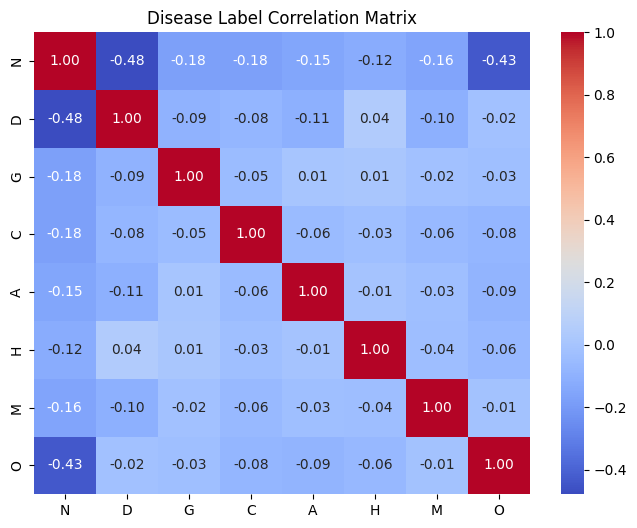

In [5]:
# Compute correlation between labels
corr = df[label_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Disease Label Correlation Matrix")
plt.show()

## Section 4 - Convert Patient-Level Labels to Image-Level Labels

Each patient has:
- One left-eye fundus image
- One right-eye fundus image

We convert each eye into an **independent training sample** while keeping the same disease labels.

In [9]:
# Image-Level Expansion
image_records = []

for _, row in df.iterrows():
    # Extract labels once
    labels = row[label_cols].values.astype(int)
    
    # Left eye image
    image_records.append({
        "image_name": row["Left-Fundus"],
        "eye": "left",
        "split": "train",  # provisional, refined later
        **dict(zip(label_cols, labels))
    })
    
    # Right eye image
    image_records.append({
        "image_name": row["Right-Fundus"],
        "eye": "right",
        "split": "train",
        **dict(zip(label_cols, labels))
    })

# Create image-level dataframe
image_df = pd.DataFrame(image_records)

image_df.head()

,image_name,eye,split,N,D,G,C,A,H,M,O
0,0_left.jpg,left,train,0,0,0,1,0,0,0,0
1,0_right.jpg,right,train,0,0,0,1,0,0,0,0
2,1_left.jpg,left,train,1,0,0,0,0,0,0,0
3,1_right.jpg,right,train,1,0,0,0,0,0,0,0
4,2_left.jpg,left,train,0,1,0,0,0,0,0,1


In [8]:
image_df.tail()

,image_name,eye,split,N,D,G,C,A,H,M,O
6995,4689_right.jpg,right,train,0,1,0,0,0,0,0,0
6996,4690_left.jpg,left,train,0,1,0,0,0,0,0,0
6997,4690_right.jpg,right,train,0,1,0,0,0,0,0,0
6998,4784_left.jpg,left,train,0,0,0,0,1,1,0,0
6999,4784_right.jpg,right,train,0,0,0,0,1,1,0,0


## Verify Image Existence

We confirm that generated image filenames exist in the dataset folders.

In [10]:
train_images = set(p.name for p in TRAIN_IMG_DIR.iterdir())
test_images = set(p.name for p in TEST_IMG_DIR.iterdir())

def locate_image(fname):
    if fname in train_images:
        return "train"
    elif fname in test_images:
        return "test"
    else:
        return "missing"

image_df["split"] = image_df["image_name"].apply(locate_image)

# Count results
image_df["split"].value_counts()

split
train    7000
Name: count, dtype: int64

## Section 5 - Filter Valid Training Samples

Only images found in the official training set are retained for training and validation.

In [11]:
train_df = image_df[image_df["split"] == "train"].reset_index(drop=True)

print(f"Number of image-level training samples: {len(train_df)}")
train_df.head()

Number of image-level training samples: 7000


,image_name,eye,split,N,D,G,C,A,H,M,O
0,0_left.jpg,left,train,0,0,0,1,0,0,0,0
1,0_right.jpg,right,train,0,0,0,1,0,0,0,0
2,1_left.jpg,left,train,1,0,0,0,0,0,0,0
3,1_right.jpg,right,train,1,0,0,0,0,0,0,0
4,2_left.jpg,left,train,0,1,0,0,0,0,0,1


## Section 6 - Image-Level Label Distribution

We re-check class imbalance after converting to image-level samples.

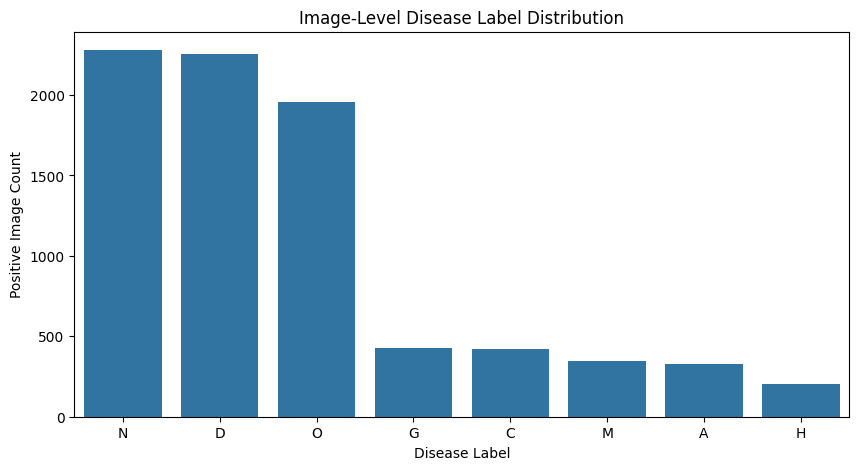

In [12]:
# Plot Image-Level Distribution
label_counts = train_df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Image-Level Disease Label Distribution")
plt.ylabel("Positive Image Count")
plt.xlabel("Disease Label")
plt.show()

## Section 7 - Save Clean Image-Level Dataset

This file will be used in the next notebook to create reproducible train/validation splits.

In [13]:
# Save CSV
OUTPUT_DIR = DATA_DIR / "processed"
OUTPUT_DIR.mkdir(exist_ok=True)

image_level_path = OUTPUT_DIR / "image_level_labels.csv"
train_df.to_csv(image_level_path, index=False)

print(f"Saved image-level labels to: {image_level_path}")

Saved image-level labels to: c:\Users\ibaan\Documents\Coding\Python\odir_ocular_disease_recognition\data\processed\image_level_labels.csv


## Key Outcomes

- Patient-level annotations were successfully converted into **image-level samples**
- Each fundus image now has a corresponding multi-label target vector
- Class imbalance persists at the image level, reinforcing the need for weighted losses or focal loss
- A clean, reproducible metadata file is ready for dataset splitting